In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
df_baseline = pd.read_csv("../../results/baseline_results.csv")
df_held_out = pd.read_csv("../../results/held_out_rag_results.csv")
df_derm = pd.read_csv("../../results/derm.csv")

In [17]:
df_baseline = df_baseline.rename(
    {"logprobs": "logprobs_baseline", "response" : "response_baseline"}, 
    axis=1
)


In [18]:
df_baseline = df_baseline.drop("answer", axis=1)

In [19]:
print(df_baseline["id"].dtype)


object


In [20]:
df_held_out = df_held_out.rename(
    {"logprobs" : "logprobs_held_out", "response" : "response_held_out"},
    axis=1,
)

df_held_out = df_held_out.drop("answer", axis=1)

In [21]:
print(df_held_out["id"].dtype)

object


In [22]:
df_derm = df_derm.rename(
    {"response" : "response_derm", "logprobs" : "logprobs_derm"},
    axis=1
)

In [23]:
df_merged = df_baseline.merge(df_held_out, on="id", how="inner")
df_merged = df_merged.merge(df_derm, on="id", how="inner")


In [24]:
print(df_merged)

                  id                                  response_baseline  \
0    doc7_question_0  The overarching blood pressure treatment goal ...   
1    doc7_question_1  Weight loss is emphasized as the most importan...   
2    doc7_question_2  \nConfidence: 80%\nCitation: /content/extracte...   
3    doc7_question_3  \nConfidence: 80%\n\nCitation: /content/extrac...   
4    doc7_question_4  \nConfidence: 80%\n\nCitation: /content/extrac...   
5    doc2_question_0  Shared decision-making is important in the car...   
6    doc2_question_1  \nConfidence: 80%\nCitation: /content/extracte...   
7    doc2_question_2  \nConfidence: 80%\n\nCitation: /content/extrac...   
8    doc2_question_3  \nConfidence: 80%\nCitation: doc2.pdf\n\nThe r...   
9    doc2_question_4  \nConfidence: 80%\nCitation: /content/extracte...   
10   doc1_question_0  \nConfidence: 80%\nCitation: ESC Guidelines, D...   
11   doc1_question_1  \nConfidence: 80%\nCitation: /content/extracte...   
12   doc1_question_2  Ans

# Calculating the mean and variance of the top 10k tokens at each step

In [25]:
import ast

# Fix each logprobs column
for col in ["logprobs_baseline", "logprobs_held_out", "logprobs_derm"]:
    df_merged[col] = df_merged[col].apply(lambda x: ast.literal_eval(x))

In [26]:
def calculate_avg_prob(col_name):
    seqs = df_merged[col_name]
    seqs = [np.array(x).squeeze(1) for x in seqs]


    # Compute max sequence length + top_k dimension
    max_T = max(s.shape[0] for s in seqs)
    top_k = max(s.shape[1] for s in seqs)

    # Allocate padding
    padded = np.full((len(seqs), max_T, top_k), np.nan)

    for i, s in enumerate(seqs):
        T, K = s.shape
        padded[i, :T, :K] = s

    # Basic statistics
    top1 = padded[:, :, 0]

    mean_top1 = np.nanmean(top1, axis=0)
    var_top1 = np.nanvar(top1, axis=0)

    mean_all = np.nanmean(padded, axis=0)
    mean_all = np.mean(mean_all, axis=-1)   # shape (150,)
    var_all = np.nanvar(padded, axis=0)
    var_all = np.nanvar(var_all, axis=-1)

    return max_T, mean_top1, var_top1, mean_all, var_all


In [27]:
max_T, base_mean_t1, base_var_t1, base_mean_a, base_var_a = calculate_avg_prob("logprobs_baseline")
_, ho_mean_t1, ho_var_t1, ho_mean_a, ho_var_a = calculate_avg_prob("logprobs_held_out")
_, d_mean_t1, d_var_t1, d_mean_a, d_var_a = calculate_avg_prob("logprobs_derm")

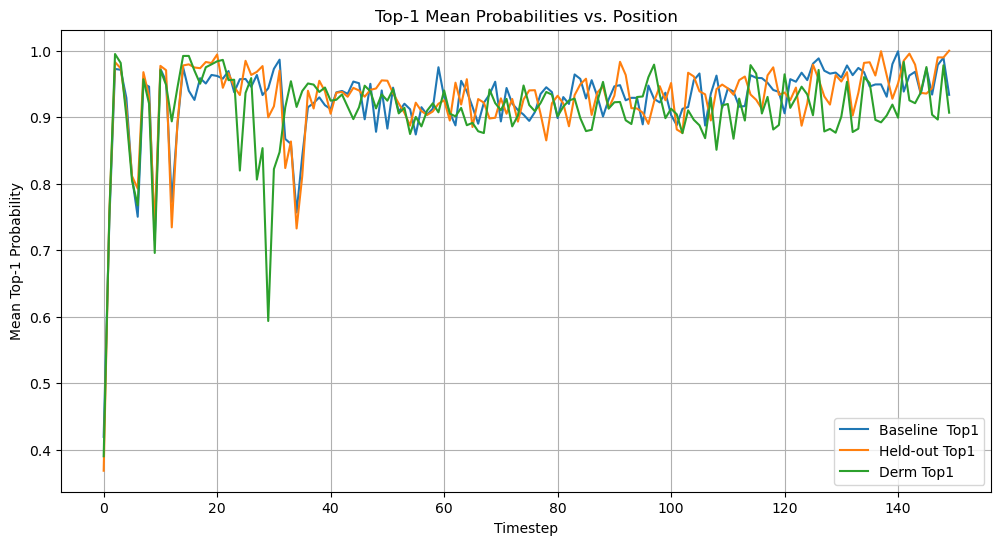

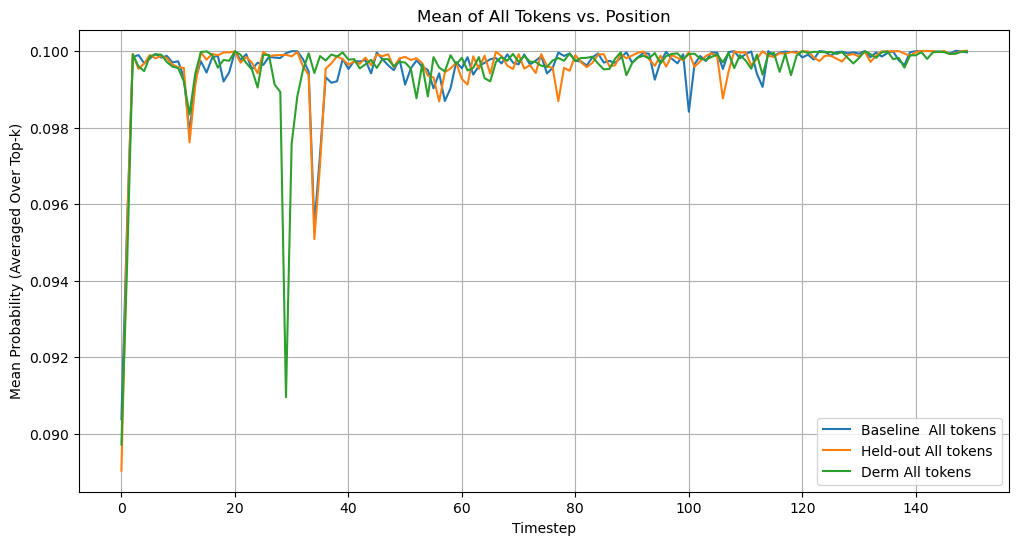

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# --- unpack your already computed arrays ---
# max_T, base_mean_t1, base_var_t1, base_mean_a, base_var_a = ...
# _, ho_mean_t1, ho_var_t1, ho_mean_a, ho_var_a = ...
# _, d_mean_t1, d_var_t1, d_mean_a, d_var_a = ...

timesteps = np.arange(max_T)

plt.figure(figsize=(12, 6))
plt.title("Top-1 Mean Probabilities vs. Position")
plt.plot(timesteps, base_mean_t1, label="Baseline  Top1")
plt.plot(timesteps, ho_mean_t1, label="Held-out Top1")
plt.plot(timesteps, d_mean_t1, label="Derm Top1")
plt.xlabel("Timestep")
plt.ylabel("Mean Top-1 Probability")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.title("Mean of All Tokens vs. Position")
plt.plot(timesteps, base_mean_a, label="Baseline  All tokens")
plt.plot(timesteps, ho_mean_a, label="Held-out All tokens")
plt.plot(timesteps, d_mean_a, label="Derm All tokens")
plt.xlabel("Timestep")
plt.ylabel("Mean Probability (Averaged Over Top-k)")
plt.legend()
plt.grid(True)
plt.show()


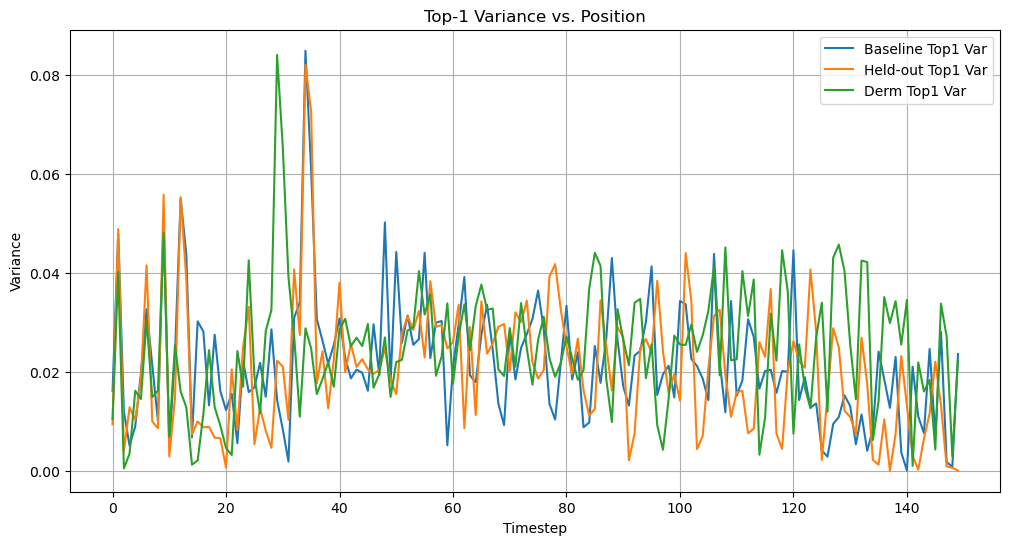

In [29]:
plt.figure(figsize=(12, 6))
plt.title("Top-1 Variance vs. Position")
plt.plot(timesteps, base_var_t1, label="Baseline Top1 Var")
plt.plot(timesteps, ho_var_t1, label="Held-out Top1 Var")
plt.plot(timesteps, d_var_t1, label="Derm Top1 Var")
plt.xlabel("Timestep")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
def calculate_entropy(col_name, topk):
    seqs = df_merged[col_name]
    seqs = [np.squeeze(np.array(s)) for s in seqs]  # now [T_i, 10]
    seqs = [s[:, :topk] for s in seqs]

    # Find max sequence length
    max_T = max(s.shape[0] for s in seqs)
    num_seqs = len(seqs)
    # vocab_topk = seqs[0].shape[1]
    vocab_topk = topk

    # Initialize padded array with NaNs (so we can ignore padding in stats)
    padded = np.full((num_seqs, max_T, vocab_topk), np.nan)

    # Fill padded array
    for i, s in enumerate(seqs):
        T = s.shape[0]
        padded[i, :T, :] = s

    # Compute entropy
    token_entropy = -np.nansum(padded * np.log(padded + 1e-12), axis=-1)  # shape [num_seqs, max_T]

    # Mean and variance per sequence (ignoring padding)
    mean_entropy_per_seq = np.nanmean(token_entropy, axis=1)
    var_entropy_per_seq = np.nanvar(token_entropy, axis=1)

    # Optionally: mean/var across all sequences at each timestep
    mean_entropy_t = np.nanmean(token_entropy, axis=0)  # shape [max_T]
    var_entropy_t = np.nanvar(token_entropy, axis=0)

    return mean_entropy_t, var_entropy_t

In [31]:
b_m_entropy, b_v_entropy = calculate_entropy("logprobs_baseline", 10)
h_m_entropy, h_v_entropy = calculate_entropy("logprobs_held_out", 10)
d_m_entropy, d_v_entropy = calculate_entropy("logprobs_derm", 10)

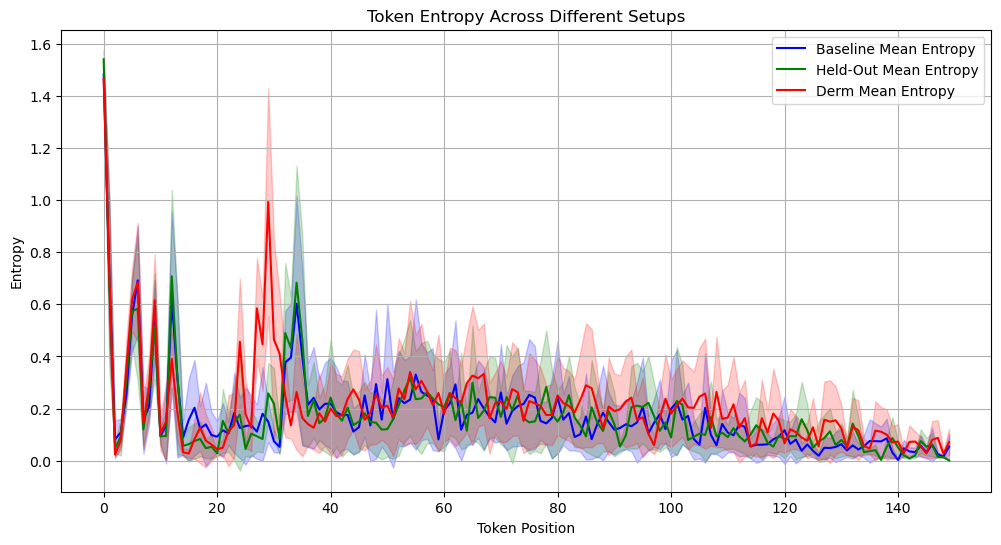

In [32]:
x = np.arange(max_T)

plt.figure(figsize=(12, 6))

# Mean entropy
plt.plot(x, b_m_entropy, label='Baseline Mean Entropy', color='blue')
plt.plot(x, h_m_entropy, label='Held-Out Mean Entropy', color='green')
plt.plot(x, d_m_entropy, label='Derm Mean Entropy', color='red')

# Optional: Add variance as shaded area
plt.fill_between(x, b_m_entropy - b_v_entropy, b_m_entropy + b_v_entropy, color='blue', alpha=0.2)
plt.fill_between(x, h_m_entropy - h_v_entropy, h_m_entropy + h_v_entropy, color='green', alpha=0.2)
plt.fill_between(x, d_m_entropy - d_v_entropy, d_m_entropy + d_v_entropy, color='red', alpha=0.2)

plt.xlabel("Token Position")
plt.ylabel("Entropy")
plt.title("Token Entropy Across Different Setups")
plt.legend()
plt.grid(True)
plt.show()

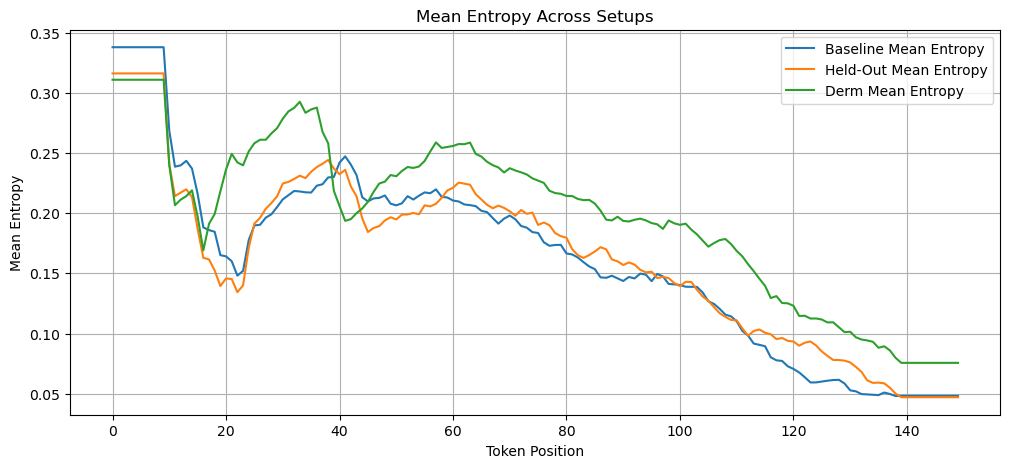

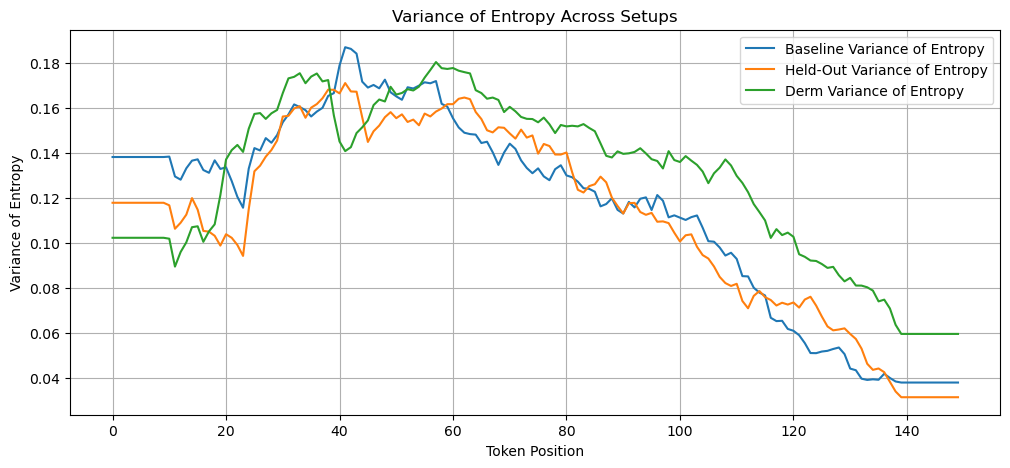

In [33]:

def plot_entropy(mean_dict, var_dict, labels=None):
    """
    Plot mean and variance of entropy for multiple setups.
    
    Args:
        mean_dict: dict of {name: mean_entropy_array}
        var_dict: dict of {name: var_entropy_array}
        labels: optional list of labels for each setup
    """
    x = np.arange(len(next(iter(mean_dict.values()))))  # assume all same length
    
    # Plot mean
    plt.figure(figsize=(12, 5))
    for name, mean_vals in mean_dict.items():
        plt.plot(x, mean_vals, label=f'{name} Mean Entropy')
    plt.xlabel("Token Position")
    plt.ylabel("Mean Entropy")
    plt.title("Mean Entropy Across Setups")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot variance
    plt.figure(figsize=(12, 5))
    for name, var_vals in var_dict.items():
        plt.plot(x, var_vals, label=f'{name} Variance of Entropy')
    plt.xlabel("Token Position")
    plt.ylabel("Variance of Entropy")
    plt.title("Variance of Entropy Across Setups")
    plt.legend()
    plt.grid(True)
    plt.show()


def sliding_window(array, window_size=5):
    """
    Compute sliding window average (smoothing) over 1D array.
    
    Args:
        array: 1D numpy array
        window_size: int, size of the sliding window
    Returns:
        smoothed array of same length (edges padded with original values)
    """
    smoothed = np.convolve(array, np.ones(window_size)/window_size, mode='valid')
    # pad to match original length
    pad_len = len(array) - len(smoothed)
    left_pad = pad_len // 2
    right_pad = pad_len - left_pad
    smoothed = np.pad(smoothed, (left_pad, right_pad), mode='edge')
    return smoothed


# Example usage:
mean_dict = {
    "Baseline": b_m_entropy,
    "Held-Out": h_m_entropy,
    "Derm": d_m_entropy
}

var_dict = {
    "Baseline": b_v_entropy,
    "Held-Out": h_v_entropy,
    "Derm": d_v_entropy
}

# Optionally smooth
for k in mean_dict:
    mean_dict[k] = sliding_window(mean_dict[k], window_size=20)
    var_dict[k] = sliding_window(var_dict[k], window_size=20)

plot_entropy(mean_dict, var_dict)


In [89]:
s_b_m_entropy = mean_dict["Baseline"]
s_h_m_entropy = mean_dict["Held-Out"]
s_d_m_entropy = mean_dict["Derm"]

In [90]:
b = []
h = []
d = []
for k in range(150):
    b_v = s_b_m_entropy[:k].mean()
    h_v = s_h_m_entropy[:k].mean()
    d_v = s_d_m_entropy[:k].mean()
    b.append(b_v)
    h.append(h_v)
    d.append(d_v)


C:\Users\laure\AppData\Local\Temp\ipykernel_34208\3291396153.py:5: RuntimeWarning: Mean of empty slice.
  b_v = s_b_m_entropy[:k].mean()
C:\Users\laure\AppData\Local\Temp\ipykernel_34208\3291396153.py:6: RuntimeWarning: Mean of empty slice.
  h_v = s_h_m_entropy[:k].mean()
C:\Users\laure\AppData\Local\Temp\ipykernel_34208\3291396153.py:7: RuntimeWarning: Mean of empty slice.
  d_v = s_d_m_entropy[:k].mean()


In [91]:
smoothed_dict = {
    "Baseline" : b,
    "Held Out": h,
    "Dermatology": d
}

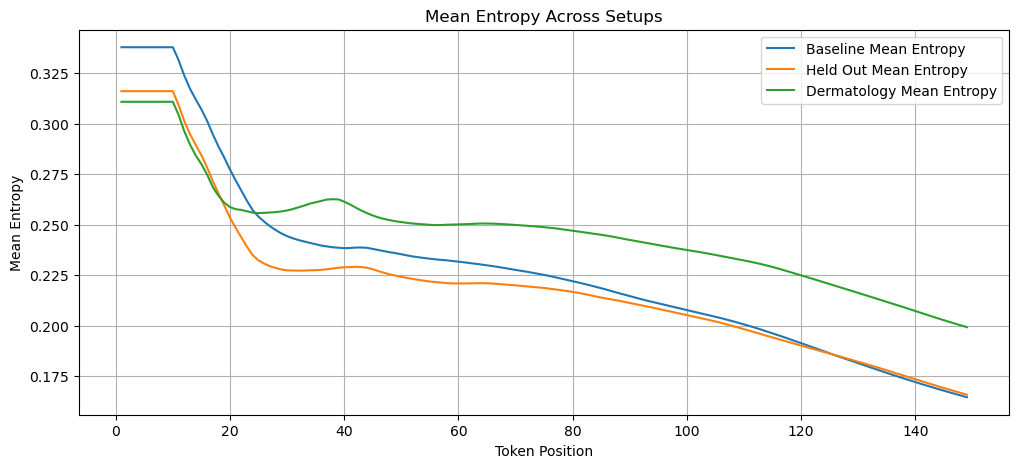

In [92]:
x = np.arange(len(next(iter(mean_dict.values()))))  # assume all same length
    
# Plot mean
plt.figure(figsize=(12, 5))
for name, mean_vals in smoothed_dict.items():
    plt.plot(x, mean_vals, label=f'{name} Mean Entropy')
plt.xlabel("Token Position")
plt.ylabel("Mean Entropy")
plt.title("Mean Entropy Across Setups")
plt.legend()
plt.grid(True)
plt.show()

In [34]:
def compute_topk_gaps(col_name, top_k=5):
    seqs = df_merged[col_name]
    seqs = [np.squeeze(np.array(s)) for s in seqs]  # list of [T_i, vocab_size] arrays

    # Find max sequence length
    max_T = max(s.shape[0] for s in seqs)
    num_seqs = len(seqs)
    vocab_size = seqs[0].shape[1]

    # Pad sequences with NaNs
    padded = np.full((num_seqs, max_T, vocab_size), np.nan)
    for i, s in enumerate(seqs):
        T = s.shape[0]
        padded[i, :T, :] = s

    # Identify the top-k indices per timestep
    # Shape [num_seqs, max_T, top_k]
    topk_indices = np.argsort(-padded, axis=-1)[:, :, :top_k]  # descending order

    # Compute gaps between the highest (0th) and the next 1st–4th
    # Shape [num_seqs, max_T, top_k-1]
    gaps = np.take_along_axis(padded, topk_indices[:, :, [0]], axis=-1) - \
           np.take_along_axis(padded, topk_indices[:, :, 1:top_k], axis=-1)

    # Mean gap per sequence across all timesteps
    mean_gap_per_seq = np.nanmean(gaps, axis=(1, 2))  # shape [num_seqs]

    # Mean and variance per timestep across sequences
    mean_gap_t = np.nanmean(gaps, axis=0)  # shape [max_T, top_k-1]
    var_gap_t = np.nanvar(gaps, axis=0)

    return mean_gap_per_seq, mean_gap_t, var_gap_t


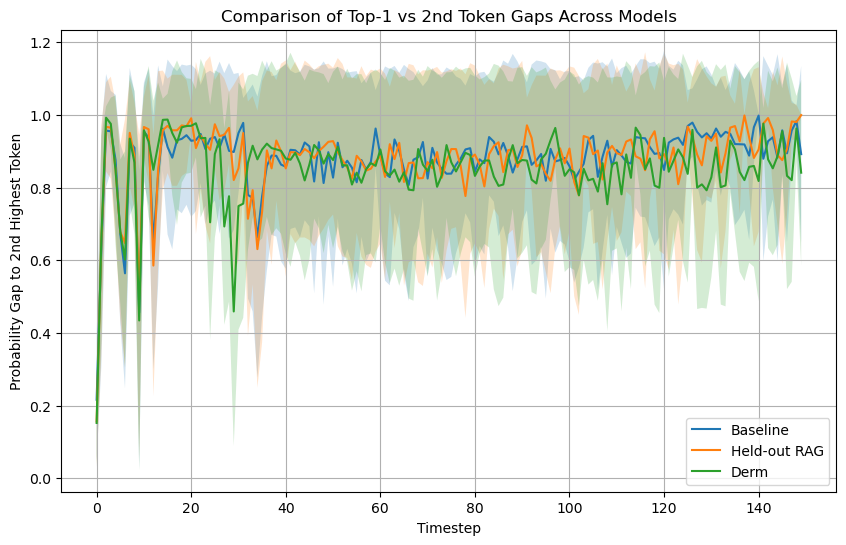

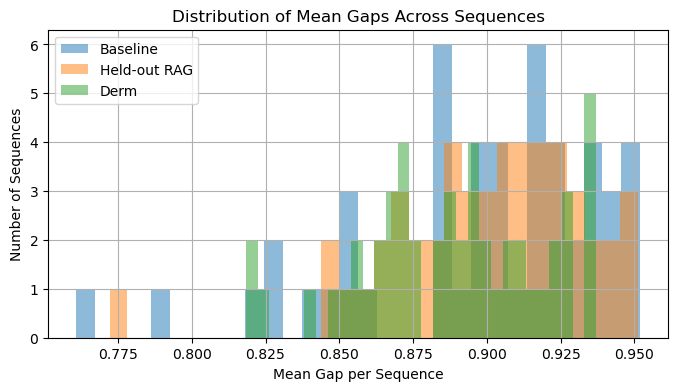

In [35]:
# Names of your columns
cols = ["logprobs_baseline", "logprobs_held_out", "logprobs_derm"]
labels = ["Baseline", "Held-out RAG", "Derm"]

# Compute gaps for all three
results = {}
top_k = 5
for col, label in zip(cols, labels):
    mean_gap_per_seq, mean_gap_t, var_gap_t = compute_topk_gaps(col, top_k=top_k)
    results[label] = {
        "mean_gap_per_seq": mean_gap_per_seq,
        "mean_gap_t": mean_gap_t,
        "var_gap_t": var_gap_t
    }

# Plot mean gaps per timestep for all 3
import matplotlib.pyplot as plt
timesteps = np.arange(results[labels[0]]["mean_gap_t"].shape[0])

plt.figure(figsize=(10, 6))
for label in labels:
    # Here we plot the gap to 2nd highest token (index 0 in top_k-1)
    mean_gap_t = results[label]["mean_gap_t"][:, 0]
    var_gap_t = results[label]["var_gap_t"][:, 0]
    plt.plot(timesteps, mean_gap_t, label=label)
    plt.fill_between(timesteps, mean_gap_t - np.sqrt(var_gap_t), mean_gap_t + np.sqrt(var_gap_t), alpha=0.2)

plt.xlabel("Timestep")
plt.ylabel("Probability Gap to 2nd Highest Token")
plt.title("Comparison of Top-1 vs 2nd Token Gaps Across Models")
plt.legend()
plt.grid(True)
plt.show()

# Optional: histogram of mean gap per sequence for all 3
plt.figure(figsize=(8, 4))
for label in labels:
    plt.hist(results[label]["mean_gap_per_seq"], bins=30, alpha=0.5, label=label)
plt.xlabel("Mean Gap per Sequence")
plt.ylabel("Number of Sequences")
plt.title("Distribution of Mean Gaps Across Sequences")
plt.legend()
plt.grid(True)
plt.show()


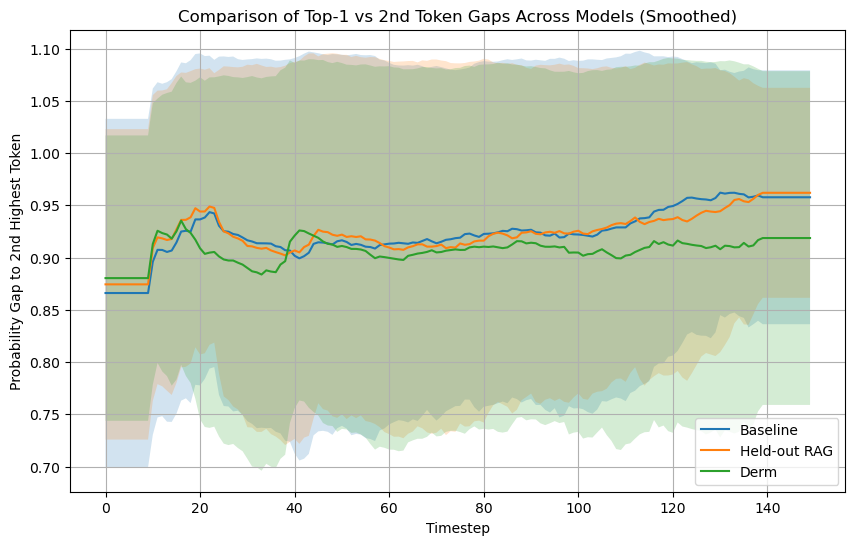

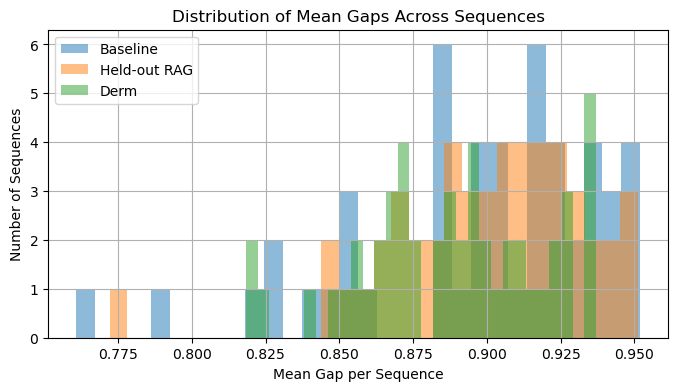

In [38]:
def sliding_window(array, window_size=20):
    """
    Compute sliding window average (smoothing) over 1D array.
    Returns array of same length.
    """
    smoothed = np.convolve(array, np.ones(window_size)/window_size, mode='valid')
    pad_len = len(array) - len(smoothed)
    left = pad_len // 2
    right = pad_len - left
    smoothed = np.pad(smoothed, (left, right), mode='edge')
    return smoothed


# Names of your columns
cols = ["logprobs_baseline", "logprobs_held_out", "logprobs_derm"]
labels = ["Baseline", "Held-out RAG", "Derm"]

# Compute gaps for all three
results = {}
top_k = 5

for col, label in zip(cols, labels):
    mean_gap_per_seq, mean_gap_t, var_gap_t = compute_topk_gaps(col, top_k=top_k)

    # ---- APPLY SLIDING WINDOW HERE ----
    mean_gap_t_smooth = sliding_window(mean_gap_t[:, 2], window_size=20)
    var_gap_t_smooth  = sliding_window(var_gap_t[:, 2], window_size=20)

    results[label] = {
        "mean_gap_per_seq": mean_gap_per_seq,
        "mean_gap_t": mean_gap_t_smooth,
        "var_gap_t": var_gap_t_smooth
    }


# Plot mean gaps per timestep for all 3
timesteps = np.arange(len(results[labels[0]]["mean_gap_t"]))

plt.figure(figsize=(10, 6))
for label in labels:
    mean_gap_t = results[label]["mean_gap_t"]
    var_gap_t = results[label]["var_gap_t"]

    plt.plot(timesteps, mean_gap_t, label=label)
    plt.fill_between(
        timesteps,
        mean_gap_t - np.sqrt(var_gap_t),
        mean_gap_t + np.sqrt(var_gap_t),
        alpha=0.2
    )

plt.xlabel("Timestep")
plt.ylabel("Probability Gap to 2nd Highest Token")
plt.title("Comparison of Top-1 vs 2nd Token Gaps Across Models (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()


# Histogram of mean gap per sequence
plt.figure(figsize=(8, 4))
for label in labels:
    plt.hist(results[label]["mean_gap_per_seq"], bins=30, alpha=0.5, label=label)

plt.xlabel("Mean Gap per Sequence")
plt.ylabel("Number of Sequences")
plt.title("Distribution of Mean Gaps Across Sequences")
plt.legend()
plt.grid(True)
plt.show()


# Significance testing

In [93]:
baseline_probs = df_merged["logprobs_baseline"]
held_out_probs = df_merged["logprobs_held_out"]
derm_probs = df_merged["logprobs_derm"]

In [94]:
baseline_probs = [np.squeeze(np.array(x)) for x in baseline_probs]
held_out_probs = [np.squeeze(np.array(x)) for x in held_out_probs]
derm_probs = [np.squeeze(np.array(x)) for x in derm_probs]

In [95]:
def pad_with_nans(seqs):
    # Find max sequence length
    max_T = max(s.shape[0] for s in seqs)
    num_seqs = len(seqs)
    vocab_size = seqs[0].shape[1]

    # Pad sequences with NaNs
    padded = np.full((num_seqs, max_T, vocab_size), np.nan)
    for i, s in enumerate(seqs):
        T = s.shape[0]
        padded[i, :T, :] = s
    return padded


In [96]:
baseline_probs = pad_with_nans(baseline_probs)
held_out_probs = pad_with_nans(held_out_probs)
derm_probs = pad_with_nans(derm_probs)

In [97]:
def compute_entropy_from_probs(prob_array):
    """
    prob_array: shape (N, T, K), K=10
    returns entropy of shape (N, T)
    """
    eps = 1e-12
    return -np.sum(prob_array * np.log(prob_array + eps), axis=-1)

In [98]:
baseline_entropy = compute_entropy_from_probs(baseline_probs)
held_out_entropy = compute_entropy_from_probs(held_out_probs)
derm_entropy = compute_entropy_from_probs(derm_probs)

In [99]:
def sliding_window_2d(arr, window_size=20):
    """
    Smooth along axis=1 (token axis) using a sliding window mean.
    Works for arrays of shape (N, T).
    Returns array of same shape.
    """
    N, T = arr.shape
    
    # 1D smoothing kernel
    kernel = np.ones(window_size) / window_size
    
    # Output array
    smoothed = np.zeros_like(arr)
    
    for i in range(N):
        # convolve 1D row
        conv = np.convolve(arr[i], kernel, mode='valid')
        
        # pad back to length T
        pad = T - conv.shape[0]
        left = pad // 2
        right = pad - left
        
        smoothed[i] = np.pad(conv, (left, right), mode='edge')
    
    return smoothed


In [100]:
smoothed_baseline = sliding_window_2d(baseline_entropy)
smooted_ho = sliding_window_2d(held_out_entropy)
smooted_derm = sliding_window_2d(derm_entropy)

In [131]:
def bootstrap_pvalue(a, b, n_boot=100000):
    """
    a, b: shape (num_sequences,) arrays of per-sequence values
    Returns: p-value, prints Cohen's d
    """
    mask = ~np.isnan(a) & ~np.isnan(b)
    a, b = a[mask], b[mask]

    if len(a) == 0:
        print("No valid data for comparison!")
        return np.nan

    diffs = a - b
    observed = diffs.mean()

    std = diffs.std(ddof=1)
    cohen_d = observed / std if std > 0 else 0.0
    print("Cohen's d:", cohen_d)

    boot = []
    for _ in range(n_boot):
        signs = np.random.choice([-1, 1], size=len(diffs))
        boot.append((diffs * signs).mean())

    p = np.mean(np.abs(boot) >= np.abs(observed))
    return p


# --- Sliding-window mean for sequences ---
def sliding_window_mean(seqs, k):
    """
    seqs: shape (num_sequences, T)
    k: number of tokens to include in sliding/cumulative average
    Returns: shape (num_sequences,)
    """
    return np.nanmean(seqs[:, :k], axis=1)


for k in range(0, 25):
    print(k)

    baseline_mean = sliding_window_mean(smoothed_baseline, k)
    held_out_mean = sliding_window_mean(smooted_ho, k)
    derm_mean = sliding_window_mean(smooted_derm, k)

    # Compare baseline vs held-out
    p_b_h = bootstrap_pvalue(baseline_mean, held_out_mean)
    p_b_d = bootstrap_pvalue(baseline_mean, derm_mean)
    p_h_d = bootstrap_pvalue(held_out_mean, derm_mean)

    print("Bootstrap Baseline vs Held-Out:", p_b_h)
    print("Bootstrap Baseline vs Derm:", p_b_d)
    print("Bootstrap Held-Out vs Derm:", p_h_d)

0
No valid data for comparison!
No valid data for comparison!
No valid data for comparison!
Bootstrap Baseline vs Held-Out: nan
Bootstrap Baseline vs Derm: nan
Bootstrap Held-Out vs Derm: nan
1
Cohen's d: 0.20340848348619922


C:\Users\laure\AppData\Local\Temp\ipykernel_34208\3641232449.py:36: RuntimeWarning: Mean of empty slice
  return np.nanmean(seqs[:, :k], axis=1)


Cohen's d: 0.19230788218395017
Cohen's d: 0.04283061270226662
Bootstrap Baseline vs Held-Out: 0.15963
Bootstrap Baseline vs Derm: 0.18262
Bootstrap Held-Out vs Derm: 0.78736
2
Cohen's d: 0.20340848348619922
Cohen's d: 0.19230788218395017
Cohen's d: 0.04283061270226662
Bootstrap Baseline vs Held-Out: 0.15844
Bootstrap Baseline vs Derm: 0.18448
Bootstrap Held-Out vs Derm: 0.78624
3
Cohen's d: 0.20340848348619922
Cohen's d: 0.19230788218395012
Cohen's d: 0.04283061270226665
Bootstrap Baseline vs Held-Out: 0.1606
Bootstrap Baseline vs Derm: 0.18422
Bootstrap Held-Out vs Derm: 0.78785
4
Cohen's d: 0.20340848348619922
Cohen's d: 0.19230788218395017
Cohen's d: 0.04283061270226662
Bootstrap Baseline vs Held-Out: 0.15939
Bootstrap Baseline vs Derm: 0.18358
Bootstrap Held-Out vs Derm: 0.78724
5
Cohen's d: 0.20340848348619925
Cohen's d: 0.19230788218395017
Cohen's d: 0.042830612702266686
Bootstrap Baseline vs Held-Out: 0.15932
Bootstrap Baseline vs Derm: 0.18233
Bootstrap Held-Out vs Derm: 0.7848

(50,)


In [135]:
for k in range(0, 25):
    print("Token:", k)

    baseline_col = smoothed_baseline[:, k]
    held_out_col = smooted_ho[:, k]
    derm_col = smooted_derm[:, k]

    # Compare baseline vs held-out
    p_b_h = bootstrap_pvalue(baseline_col, held_out_col)
    p_b_d = bootstrap_pvalue(baseline_col, derm_col)
    p_h_d = bootstrap_pvalue(held_out_col, derm_col)

    print("Bootstrap Baseline vs Held-Out:", p_b_h)
    print("Bootstrap Baseline vs Derm:", p_b_d)
    print("Bootstrap Held-Out vs Derm:", p_h_d)


Token: 0
Cohen's d: 0.20340848348619922
Cohen's d: 0.19230788218395017
Cohen's d: 0.04283061270226662
Bootstrap Baseline vs Held-Out: 0.16086
Bootstrap Baseline vs Derm: 0.18329
Bootstrap Held-Out vs Derm: 0.78514
Token: 1
Cohen's d: 0.20340848348619922
Cohen's d: 0.19230788218395017
Cohen's d: 0.04283061270226662
Bootstrap Baseline vs Held-Out: 0.15855
Bootstrap Baseline vs Derm: 0.18446
Bootstrap Held-Out vs Derm: 0.78472
Token: 2
Cohen's d: 0.20340848348619922
Cohen's d: 0.19230788218395017
Cohen's d: 0.04283061270226662
Bootstrap Baseline vs Held-Out: 0.15855
Bootstrap Baseline vs Derm: 0.18413
Bootstrap Held-Out vs Derm: 0.78456
Token: 3
Cohen's d: 0.20340848348619922
Cohen's d: 0.19230788218395017
Cohen's d: 0.04283061270226662
Bootstrap Baseline vs Held-Out: 0.15863
Bootstrap Baseline vs Derm: 0.18484
Bootstrap Held-Out vs Derm: 0.78549
Token: 4
Cohen's d: 0.20340848348619922
Cohen's d: 0.19230788218395017
Cohen's d: 0.04283061270226662
Bootstrap Baseline vs Held-Out: 0.15783
Bo

In [120]:
print("Baseline NaNs:", np.isnan(smoothed_baseline).sum())
print("Held-out NaNs:", np.isnan(smooted_ho).sum())
print("Derm NaNs:", np.isnan(smooted_derm).sum())


Baseline NaNs: 1955
Held-out NaNs: 1867
Derm NaNs: 1706
